In [1]:
# test for cuda and cudnn
import torch
print("version", torch.__version__)
print("cuda available", torch.cuda.is_available())
print("cudnn", torch.backends.cudnn.enabled)
print("device_name", torch.cuda.get_device_name(0))
print("device count", torch.cuda.device_count())
print("current dev", torch.cuda.current_device())
print("device zero", torch.cuda.device(0))


version 2.1.2
cuda available True
cudnn True
device_name NVIDIA GeForce GTX TITAN X
device count 4
current dev 0
device zero <torch.cuda.device object at 0x7fbcc8634be0>


In [8]:
from ocatari.core import OCAtari
import random

env = OCAtari("MsPacman-v4", mode="vision", hud=True, render_mode="rgb_array")
observation, info = env.reset()
env.objects

[Player at (78, 103), (9, 10),
 Ghost at (79, 57), (9, 10),
 Ghost at (79, 57), (9, 10),
 Ghost at (79, 57), (9, 10),
 Ghost at (79, 57), (9, 10)]

In [9]:
from ocatari.ram.extract_ram_info import detect_objects_raw, detect_objects_revised, init_objects, get_max_objects

objects = init_objects("MsPacman", True)
objects

[Player at (78, 103), (9, 10),
 Ghost at (79, 57), (9, 10),
 Ghost at (79, 57), (9, 10),
 Ghost at (79, 57), (9, 10),
 Ghost at (79, 57), (9, 10),
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

## RETRIEVE LOGS

In [1]:
# Base directory path
#base_dir = 'logs/runs/dreamer_v3/MsPacmanNoFrameskip-v4'
base_dir = 'logs/runs/dreamer_v3/BreakoutNoFrameskip-v4'

In [2]:
import os
import shutil
import glob

#### CLEAN UP MEMMAP BUFFER FOLDERS ####

# Iterate through each EXP_NAME folder
count = 0
for exp_dir in glob.glob(os.path.join(base_dir, '*')):
    version_dir = os.path.join(exp_dir, 'version_0')
    test_videos_path = os.path.join(version_dir, 'test_videos')
    memmap_buffer_path = os.path.join(version_dir, 'memmap_buffer')

    # Check if test_videos exists
    if os.path.exists(test_videos_path) and os.path.isdir(memmap_buffer_path):
        count += 1
        # Delete the contents of memmap_buffer
        for file in os.listdir(memmap_buffer_path):
            file_path = os.path.join(memmap_buffer_path, file)
            try:
                if os.path.isfile(file_path) or os.path.islink(file_path):
                    os.unlink(file_path)
                elif os.path.isdir(file_path):
                    shutil.rmtree(file_path)
            except Exception as e:
                print(f"Failed to delete {file_path}. Reason: {e}")
        # delete folder
        os.rmdir(memmap_buffer_path)

print(f"Total number of experiments processed/memmap deleted: {count}")

Total number of experiments processed/memmap deleted: 15


In [3]:
import os
import pandas as pd
from cv2 import exp
import pandas as pd
from requests import get
import yaml
from tensorboard.backend.event_processing import event_accumulator
import matplotlib.pyplot as plt
import seaborn as sns

def create_experiment_df(tensorboard_path, config_path):
    # Load TensorBoard data
    ea = event_accumulator.EventAccumulator(tensorboard_path)
    ea.Reload()

    # Load config data
    with open(config_path, 'r') as file:
        config = yaml.safe_load(file)

    # Extract parameters from config
    def get_model_size(model_size):
        if model_size == 256:
            return 'XS'
        elif model_size == 512:
            return 'S'
        else:
            return 'Not found'
        
    def get_mlp_keys(mlp_keys: dict):
        if mlp_keys['encoder'] == []:
            return 'None'
        elif mlp_keys['decoder'] == ["objects_position"]:
            return 'autoencoding'
        elif mlp_keys['encoder'] == ["objects_position"]:
            return 'enconding_only'
        else:
            return 'Not found'
        
    def get_env_target(env_target):
        if env_target == "gymnasium.make":
            return 'gym'
        elif env_target == "sheeprl.envs.ocatari.OCAtariWrapper":
            return 'ocatari'
        else:
            return 'Not found'

    params = {
        'seed': config.get('seed', 'Not found'),
        'objects_positions': get_mlp_keys(config.get('algo', {}).get('mlp_keys', 'Not found')),
        'train_every': config.get('algo', {}).get('train_every', 'Not found'),
        'model_size': get_model_size(config.get('algo', {}).get('dense_units', 'Not found')),
        'env_target': get_env_target(config.get('env', {}).get('wrapper', {}).get('env', {}).get('_target_', 'Not found')),
        'run_name': config.get('run_name', 'Not found'),
    }
    # Extract metrics and populate DataFrame
    list_of_entries = []
    for key in ea.scalars.Keys():
        # skip hp_metric
        if key == 'hp_metric':
            continue
        for event in ea.Scalars(key):
            list_of_entries.append({
                'Metric': key,
                'Step': event.step,
                'Value': event.value,
                'Seed': params['seed'],
                'MLP_Keys': params['objects_positions'],
                'Train_Every': params['train_every'],
                'Model_Size': params['model_size'],
                'Env_Target': params['env_target'],
                'Run_ID': params['run_name'],
            })
    df = pd.DataFrame.from_records(list_of_entries, columns=['Metric', 'Step', 'Value', 'Seed', 'MLP_Keys', 'Train_Every', 'Model_Size', 'Env_Target', 'Run_ID'])
    return df

def process_all_experiments(logs_base_dir):
    # Pattern for TensorFlow event files and config files
    tf_event_pattern = 'events.out.tfevents.*'
    config_filename = 'config.yaml'

    # List to hold DataFrames from each experiment
    experiments_dfs = []

    # Iterate over each subdirectory in the logs directory
    for root, dirs, files in os.walk(logs_base_dir):
        for file in files:
            if file.startswith('events.out.tfevents'):
                # TensorFlow event file path
                tf_event_path = os.path.join(root, file)

                # Corresponding config file path
                config_path = os.path.join(root, config_filename)

                # Check if config file exists
                if os.path.exists(config_path):
                    experiment_df = create_experiment_df(tf_event_path, config_path)
                    experiments_dfs.append(experiment_df)

    # Concatenate all DataFrames into a single one
    all_experiments_df = pd.concat(experiments_dfs, ignore_index=True)
    print(f"Total number of experiments processed: {len(experiments_dfs)}")
    return all_experiments_df

def create_viz(df, env_id):
    metrics = df['Metric'].unique()

    for metric in metrics:
        if metric == 'hp_metric':
            continue
        print(f"Plotting for metric: {metric}")
        if metric == 'Test/cumulative_reward':
            continue
        # Group by Step and Metric, then calculate mean and std
        filtered_df = df[(df['Metric']==metric) & (df['Train_Every'] == 8) & (df['Model_Size'] == 'S') & (df['Env_Target'] == 'ocatari')]
        grouped = filtered_df.drop(columns=['Env_Target', 'Run_ID', 'Metric', 'Model_Size', 'Train_Every', 'Seed']).groupby(['Step', 'MLP_Keys'])
        mean_std_df = grouped['Value'].agg(['mean', 'std']).reset_index()

        # Plotting
        plt.figure(figsize=(10, 6))

        # Unique MLP_Keys
        mlp_keys_unique = filtered_df['MLP_Keys'].unique()

        for mlp_key in mlp_keys_unique:
            subset = mean_std_df[mean_std_df['MLP_Keys'] == mlp_key]
            
            # Plot mean
            plt.plot(subset['Step'], subset['mean'], label=f'MLP Keys: {mlp_key}')
            
            # Fill between mean ± std
            plt.fill_between(subset['Step'], subset['mean'] - subset['std'], subset['mean'] + subset['std'], alpha=0.3)

        plt.title(f'{metric} on {env_id} Grouped by MLP_Keys')
        plt.xlabel('Step')
        plt.ylabel(f'Average {metric}')
        plt.legend()
        # Save the plots and make sure directory exists before saving (convert metric names with / to _)
        plt.savefig(f'viz/{env_id}/{metric.replace("/", "_")}.png')

def update_viz(path):
    all_experiments_df = process_all_experiments(path)
    env_id = path.split('/')[3]
    # make sure viz/ENV_ID directory exists before saving 
    if not os.path.exists(f'viz/{env_id}'):
        os.makedirs(f'viz/{env_id}')
    create_viz(all_experiments_df, env_id)

Total number of experiments processed: 19


/tmp/ipykernel_2598046/2692803901.py:14: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(x="MLP_Keys", y="Value", data=filtered_df, ci="sd", palette="muted")
/tmp/ipykernel_2598046/2692803901.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="MLP_Keys", y="Value", data=filtered_df, ci="sd", palette="muted")
/local/home/keblin/miniconda3/envs/sheep/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/local/home/keblin/miniconda3/envs/sheep/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 lis

<Figure size 1000x600 with 0 Axes>

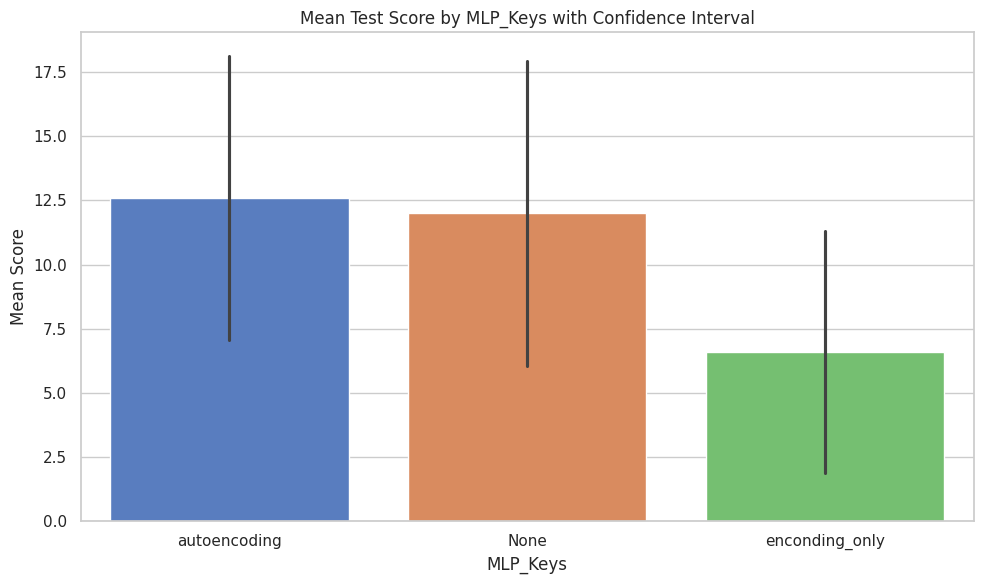

In [5]:
all_experiments_df = process_all_experiments(base_dir)

sns.set_theme(style="whitegrid")
# Plot bar plot of Test/cumulative_reward grouped by MLP_Keys, show mean and confidence interval
plt.figure(figsize=(10, 6))
filtered_df = all_experiments_df[(all_experiments_df['Metric']=='Test/cumulative_reward') & (all_experiments_df['Train_Every'] == 8) & (all_experiments_df['Model_Size'] == 'S') & (all_experiments_df['Env_Target'] == 'ocatari')]
filtered_df = filtered_df.drop(columns=['Env_Target', 'Run_ID', 'Metric', 'Model_Size', 'Train_Every', 'Seed', 'Step'])
sns.set_style("whitegrid")

# Create a bar plot showing the mean score grouped by MLP_Keys
# Seaborn automatically calculates the confidence interval (95% by default)
# and adds it as error bars
plt.figure(figsize=(10, 6))
sns.barplot(x="MLP_Keys", y="Value", data=filtered_df, ci="sd", palette="muted")

plt.title('Mean Test Score by MLP_Keys with Confidence Interval')
plt.xlabel('MLP_Keys')
plt.ylabel('Mean Score')
plt.tight_layout()  # Adjust layout to make room for the rotated x-labels
plt.show()





Total number of experiments processed: 19
Plotting for metric: Rewards/rew_avg
Plotting for metric: Game/ep_len_avg
Plotting for metric: Time/sps_env_interaction
Plotting for metric: Loss/world_model_loss
Plotting for metric: Loss/value_loss
Plotting for metric: Loss/policy_loss
Plotting for metric: Loss/observation_loss
Plotting for metric: Loss/reward_loss
Plotting for metric: Loss/state_loss
Plotting for metric: Loss/continue_loss
Plotting for metric: State/kl
Plotting for metric: State/post_entropy
Plotting for metric: State/prior_entropy
Plotting for metric: Params/exploration_amount
Plotting for metric: Grads/world_model
Plotting for metric: Grads/actor
Plotting for metric: Grads/critic
Plotting for metric: Time/sps_train
Plotting for metric: Test/cumulative_reward


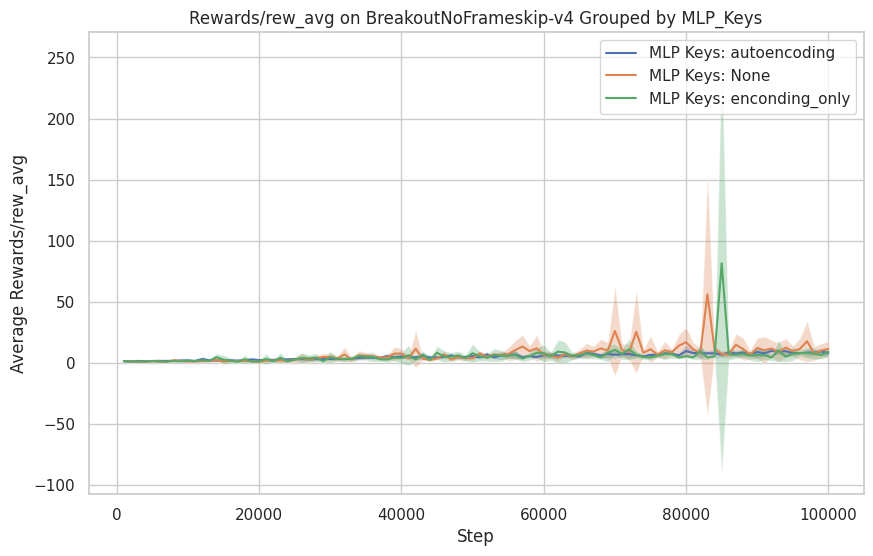

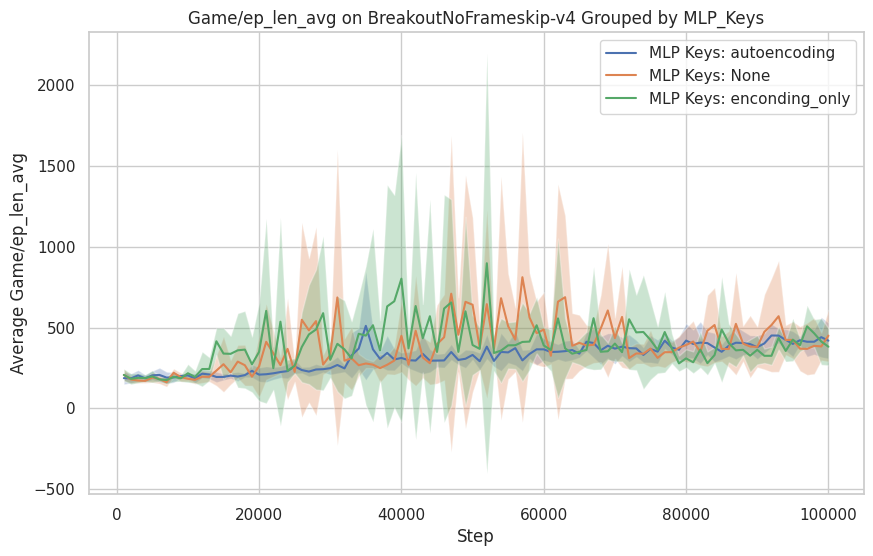

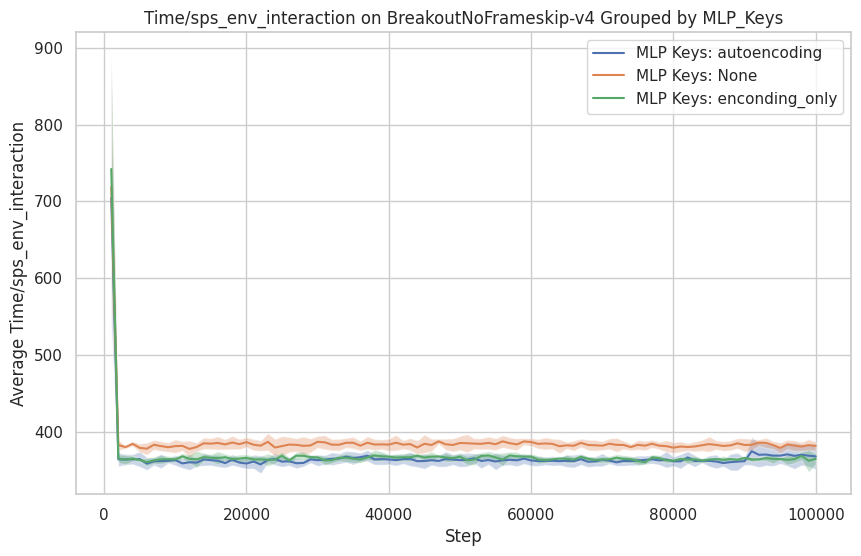

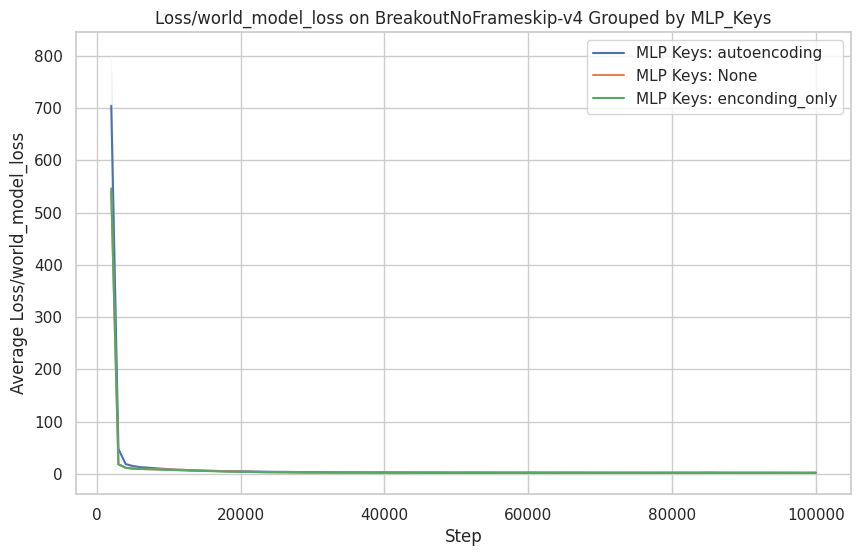

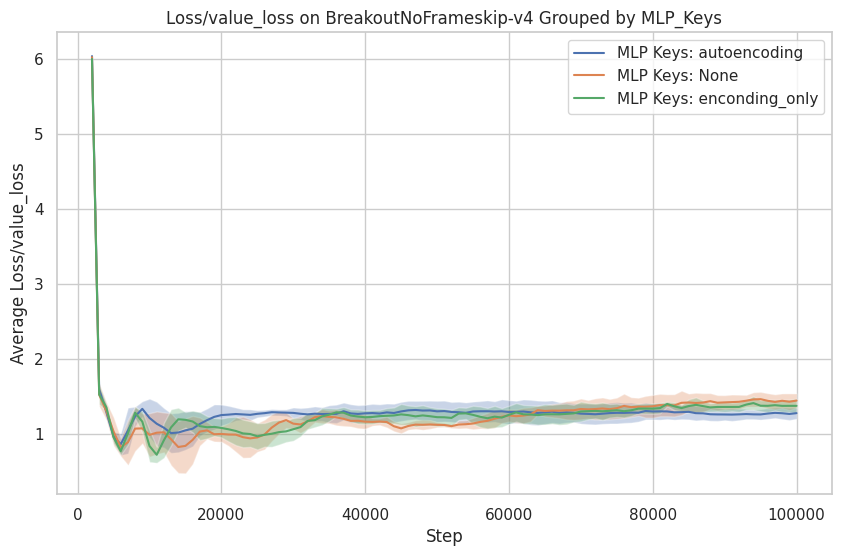

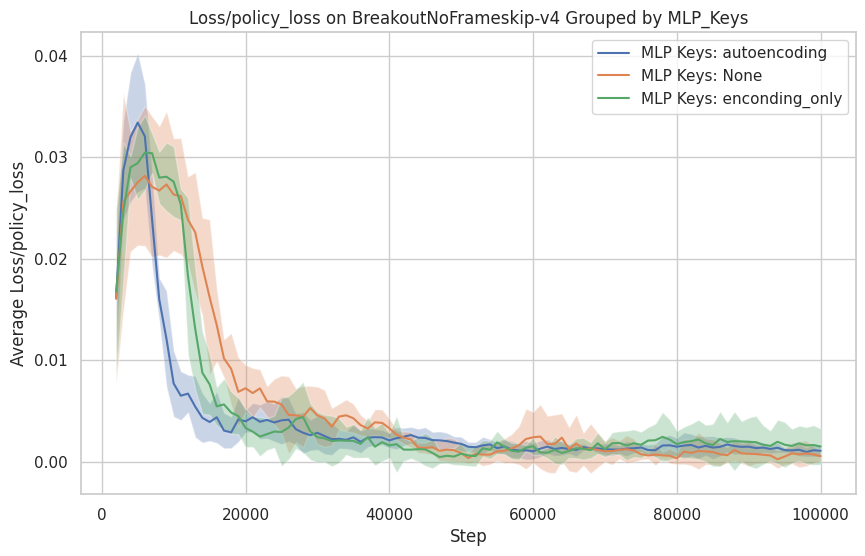

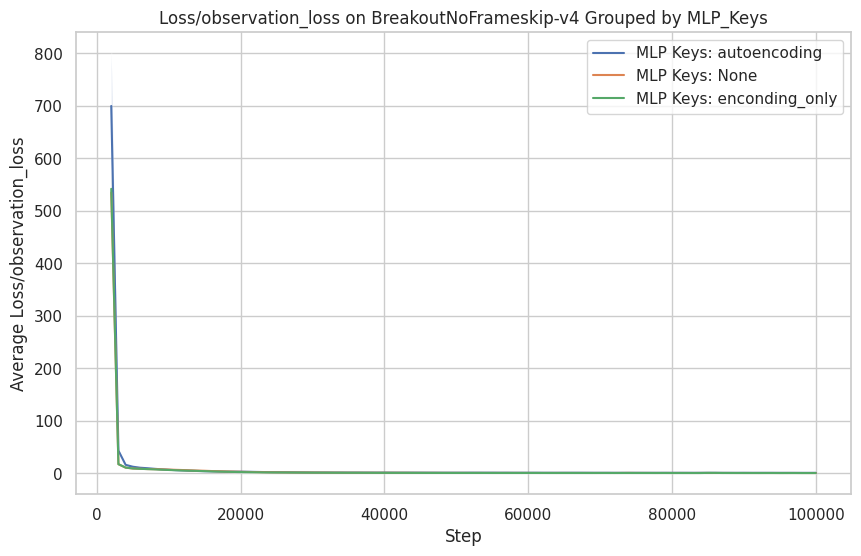

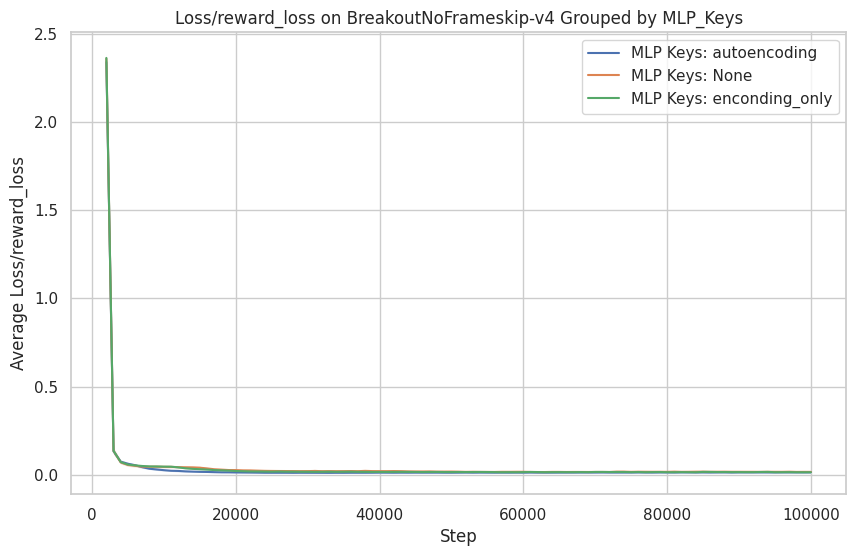

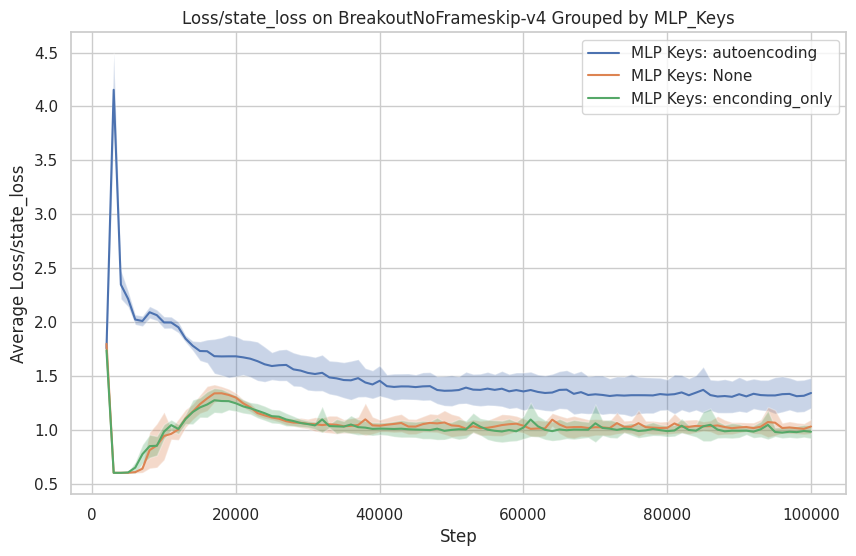

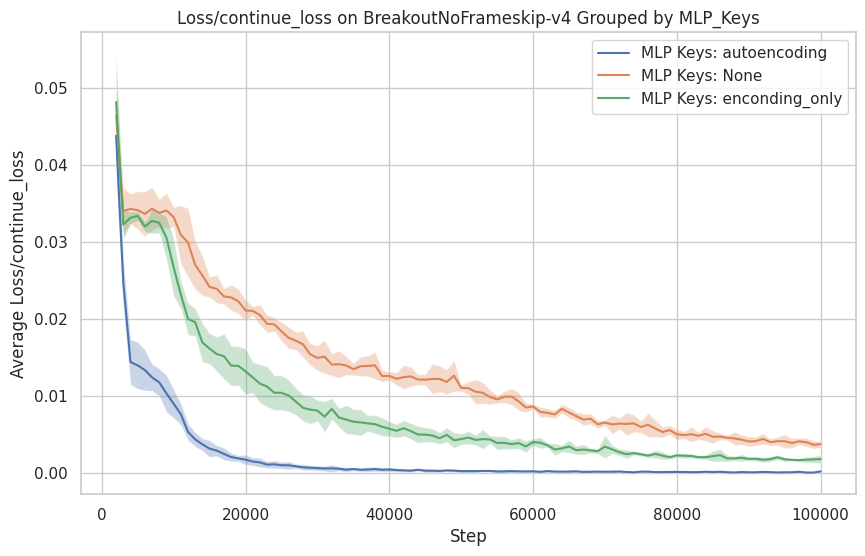

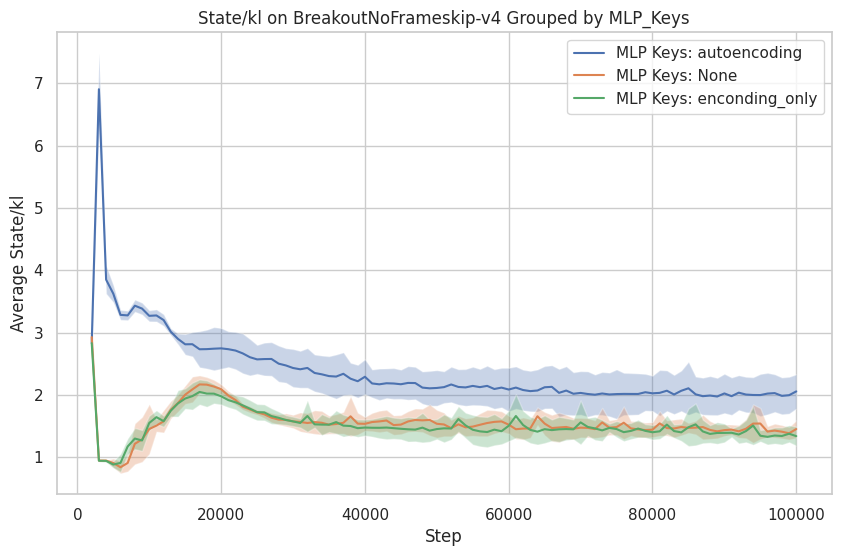

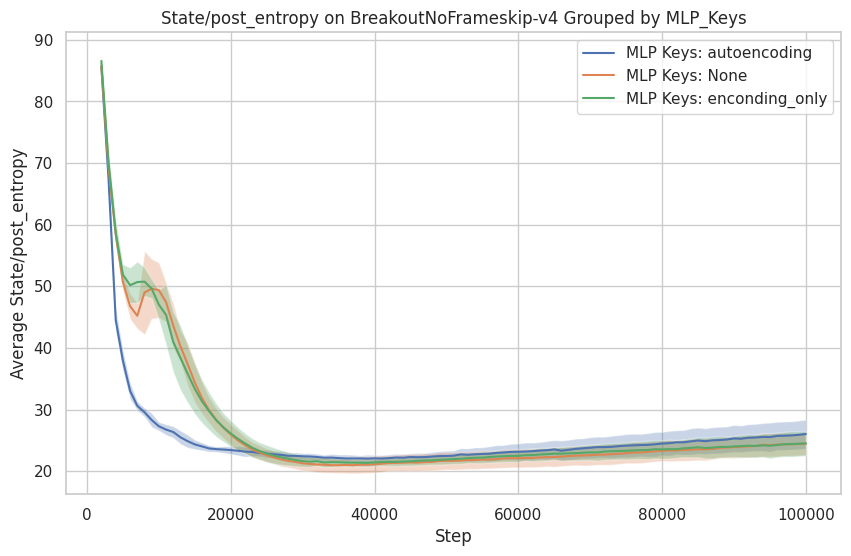

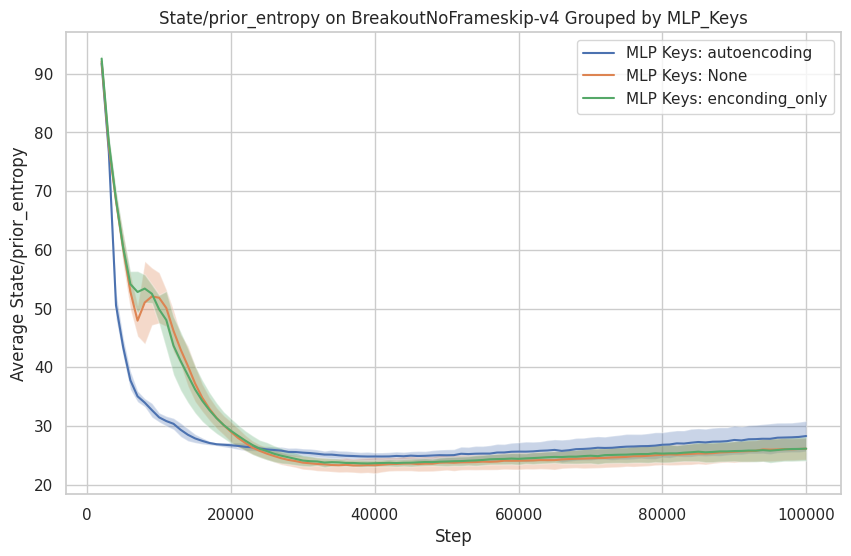

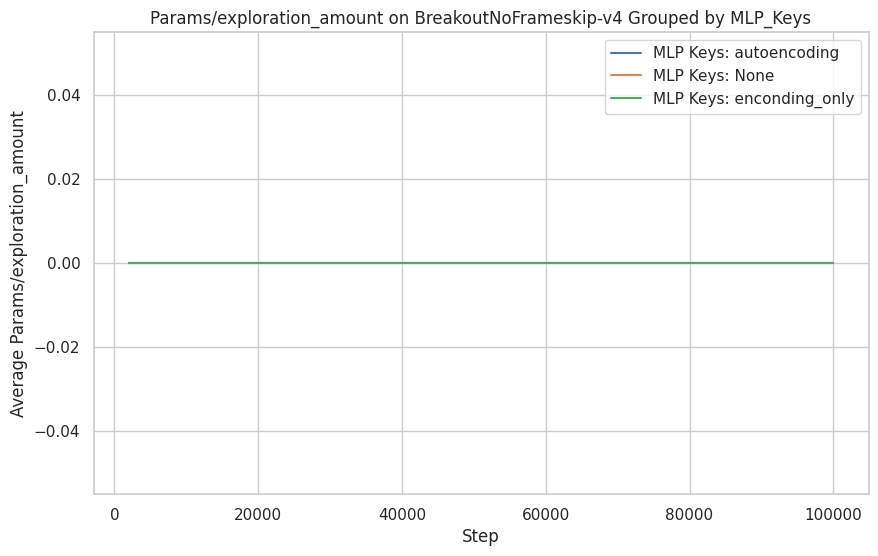

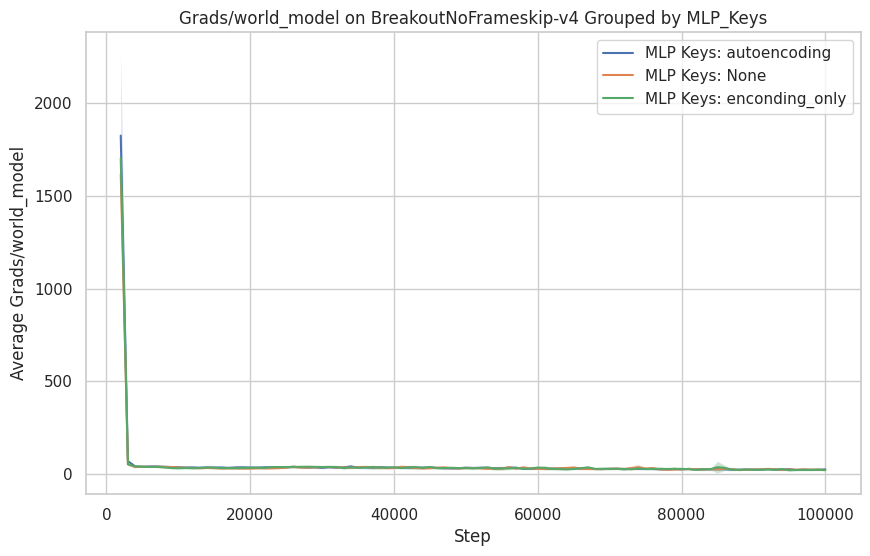

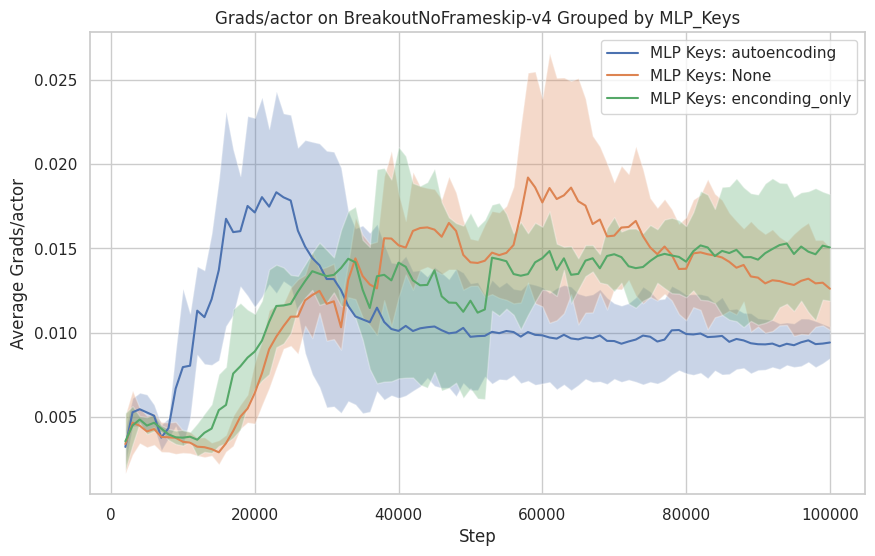

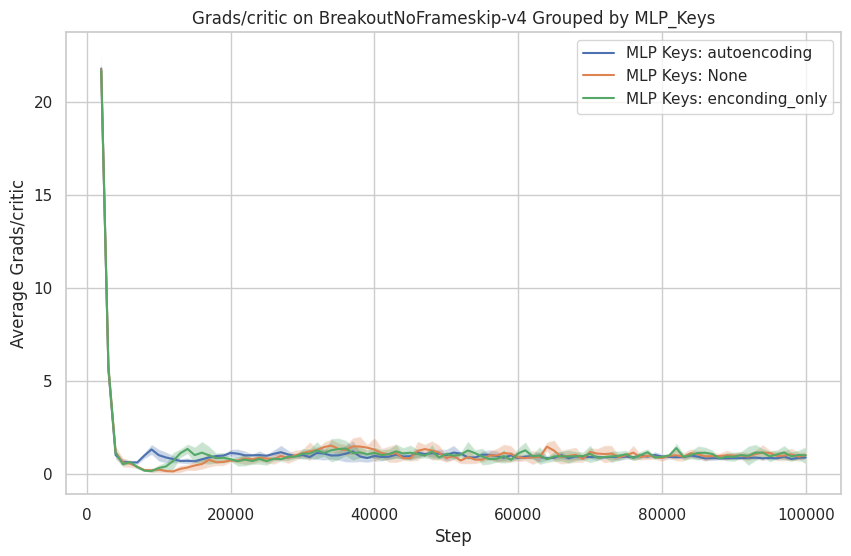

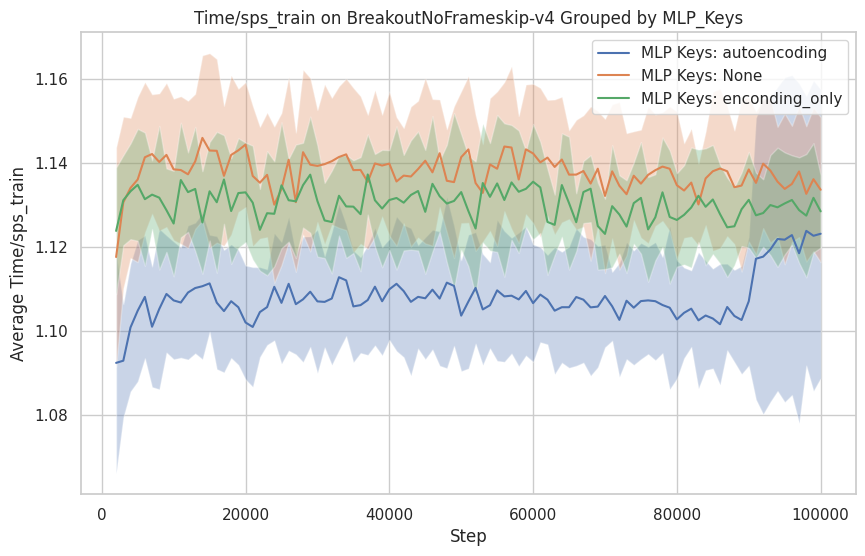

In [6]:
update_viz(base_dir)